In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os
os.chdir('/content/drive/My Drive/Colab Notebooks')

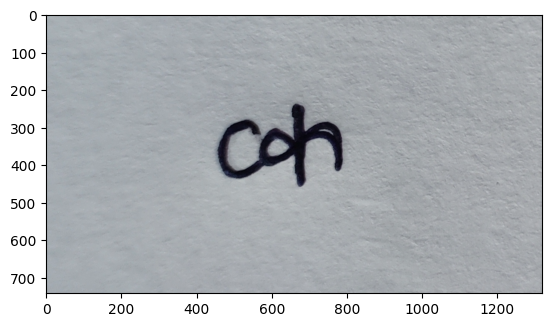

In [ ]:


#Making the necessary imports
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage.morphology import skeletonize
import imutils
from tensorflow.keras.models import load_model
from PIL import Image, ImageOps
#The inputImg represents the image that will be taken by the blind person, and
#then convert it grayscale.
inputImg = cv2.imread('/content/drive/My Drive/Colab Notebooks/Vijitha_ts/segmentation_test/15.jpg') #img_3
grayImg = cv2.cvtColor(inputImg, cv2.COLOR_BGR2GRAY)
plt.imshow(inputImg, cmap='gray')




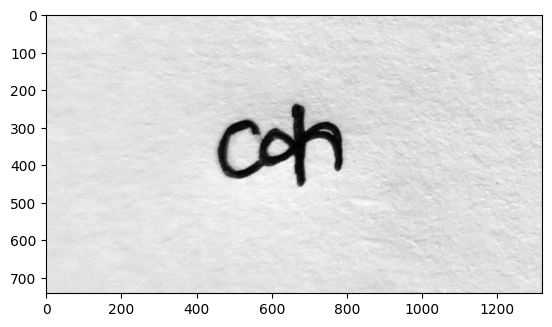

In [ ]:


#We use a filter to blur out the noise from the image.
gaussianFilter = cv2.GaussianBlur(grayImg, (5,5), 0)
plt.imshow(gaussianFilter, cmap="gray")



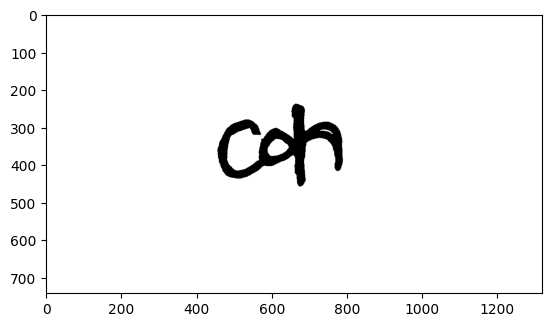

In [ ]:
#binarize and invert the image.
_, binarizedImg = cv2.threshold(gaussianFilter, 0, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)
plt.imshow(binarizedImg, cmap="gray")

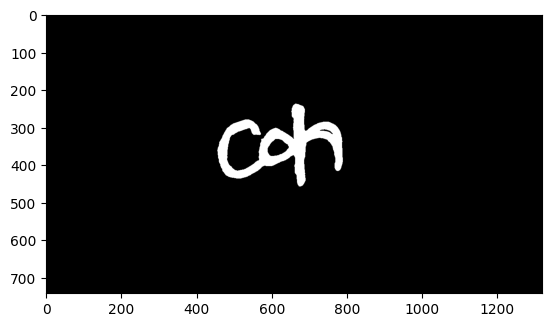

In [ ]:
binarizedImg[binarizedImg == 0] = 1
binarizedImg[binarizedImg == 255] = 0
plt.imshow(binarizedImg, cmap="gray")

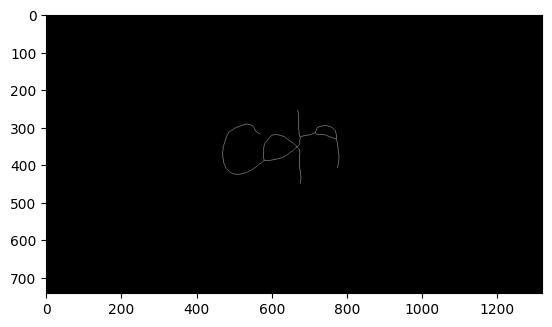

In [ ]:
#Erosion using skeletonize
skeletonImg = skeletonize(binarizedImg)
plt.imshow(skeletonImg, cmap="gray")


In [ ]:


#Horizontal and vertical projections

#horizontal_projection = np.sum(skeletonImg, axis=1)
horizontal_projection = np.sum(binarizedImg, axis=1)
print(horizontal_projection)



[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   4  10  14  17  21  25  27  29  3

In [ ]:
#height, width = skeletonImg.shape
height, width = binarizedImg.shape
print("Height: ", height)
print("Width: ", width)

Height:  741
Width:  1320


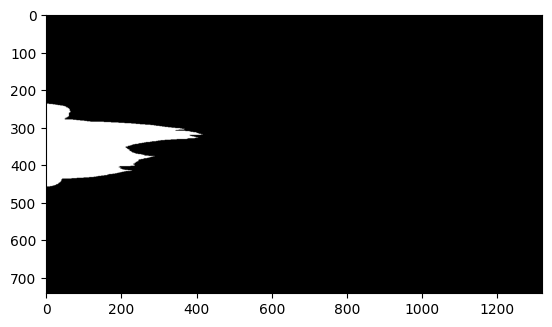

In [ ]:

#create blank canvas and fill it with the projections
blankImg = np.zeros((height, width, 3), np.uint8)
for row in range(height):
  cv2.line(blankImg, (0,row), (int(horizontal_projection[row]*width/height),row), (255,255,255), 1)

plt.imshow(blankImg, cmap="gray")

In [ ]:
#get the lines in the document using the upper and lower cut off points
upper_breakpoints = []
lower_breakpoints = []
for row in range(height-1):
  if((int(horizontal_projection[row]*width/height) == 0) and (int(horizontal_projection[row+1]*width/height)) != 0):
    upper_breakpoints.append(row)
  if((int(horizontal_projection[row]*width/height) != 0) and (int(horizontal_projection[row+1]*width/height)) == 0):
    lower_breakpoints.append(row)

print(upper_breakpoints)
print(lower_breakpoints)


[237]
[457]


In [ ]:
#store the cropped images. for later segmentation into characters and words.
images_cropped_1 = []

for num in range(len(upper_breakpoints)):
  img = binarizedImg[upper_breakpoints[num]:upper_breakpoints[num] +(lower_breakpoints[num] - upper_breakpoints[num]), 0:0+width]
  images_cropped_1.append(img)




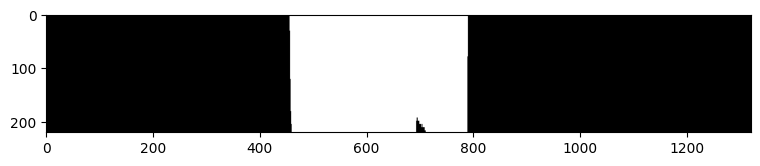

In [ ]:

#Find the characters
left_breakpoints = [[] for i in range(len(images_cropped_1))]
right_breakpoints = [[] for i in range(len(images_cropped_1))]

blankImgs = []
for i in range(len(images_cropped_1)):
  vertical_projection = np.sum(images_cropped_1[i], axis=0)
  height_2, width_2 = images_cropped_1[i].shape
  blankImg2 = np.zeros((height_2, width_2, 3), np.uint8)
  for column in range(width_2-1):
    if ((int(vertical_projection[column]*width_2/height_2) == 0) and (int(vertical_projection[column+1]*width_2/height_2) != 0)):
      left_breakpoints[i].append(column)
    if ((int(vertical_projection[column]*width_2/height_2) != 0) and (int(vertical_projection[column+1]*width_2/height_2) == 0)):
      right_breakpoints[i].append(column)
    cv2.line(blankImg2, (column, 0), (column, int(vertical_projection[column]*width_2/height_2)), (255,255,255), 1)

  blankImgs.append(blankImg2)

figure = plt.figure(figsize=(20, 20))
for i in range(len(blankImgs)):
  figure.add_subplot(2, 2, i+1)
  plt.imshow(blankImgs[i])









In [ ]:

#Find the words
left_breakpoints_2 = [[] for i in range(len(images_cropped_1))]
right_breakpoints_2 = [[] for i in range(len(images_cropped_1))]
blankWordImgs = []
for i in range(len(images_cropped_1)):
  vertical_projection_1 = np.sum(images_cropped_1[i], axis=0)
  height_3, width_3 = images_cropped_1[i].shape
  blankImg3 = np.zeros((height_3, width_3, 3), np.uint8)
  cv2.line(blankImg3, (column, 0), (column, int(vertical_projection[column]*width_2/height_2)), (255,255,255), 1)

  for column in range(width_3-1):
    if ((int(vertical_projection_1[column]*width_3/height_3) == 0) and (int(vertical_projection_1[column+1]*width_3/height_3) != 0)):
      left_breakpoints_2[i].append(column)

  for column in range(width_3-20):
    if ((int(vertical_projection_1[column]*width_3/height_3) != 0) and (int(vertical_projection_1[column+1]*width_3/height_3) == 0)):
      total = 0
      for clmn in range(20):
        total += int(vertical_projection_1[column + clmn]*width_3/height_3)
        #print(clmn,total)
      if (total == 0):
        #print(total)
        right_breakpoints_2[i].append(column)


    blankWordImgs.append(blankImg3)








In [ ]:
largest_dimension = 0  # Initialize a variable to keep track of the largest dimension
largest_image = None  # Initialize a variable to keep track of the image with the largest dimension
blah = []
previous_num2 = None
start_num = None
output = '/content/drive/My Drive/Colab Notebooks/Vijitha_ts/segmentation_output'
charImgs = []
#temp =[]
temp2=[]
xyz = []
temp = []
difference = 1000
for i in range(len(left_breakpoints)):
  prev_num = None
  for num, num2 in zip(left_breakpoints[i], right_breakpoints[i]):
    img = images_cropped_1[i]
    img = img[0:0+height_2, num: num + num2 - num]
    xyz.append(img)


    if previous_num2 is not None:
      difference = previous_num2 - num  # Calculate the difference
      print("Difference:", difference)
    #previous_num2 = num2
    #print(previous_num2)


    if abs(difference)<15:
      '''
      img = images_cropped_1[i]
      print("ddd",num,num2)
      img = img[0:0+height_2, num:num + num2 - num]
      temp.append(img)
      '''
    #img = img[0:0+height_2, num: num + num2 - num]
    #else
      if prev_num is not None:
        img2 = images_cropped_1[i]
        img2 = img2[0:0+height_2, prev_num: num2]  # Use prev_num and num2
        temp2.append(img2)  # Append the img2 in the "else" part

    prev_num = num  # Store num for the next iteration
    previous_num2 = num2









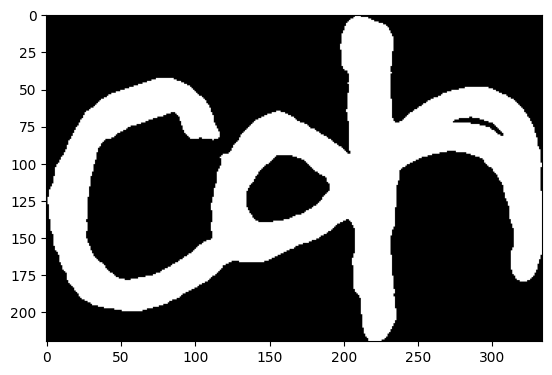

In [ ]:
blah = xyz+temp2

# Iterate through the images in the blah list
for image in blah:
    height, width = image.shape  # Get the height and width of the current image

    # Calculate the maximum dimension (width or height)
    max_dim = max(height, width)

    # Check if the current image has a larger dimension
    if max_dim > largest_dimension:
        largest_dimension = max_dim
        largest_image = image

# Display the largest image
if largest_image is not None:
    plt.imshow(largest_image, cmap='gray')
    plt.show()
else:
    print("No images in the list or failed to find the largest dimension image.")



(220, 334)


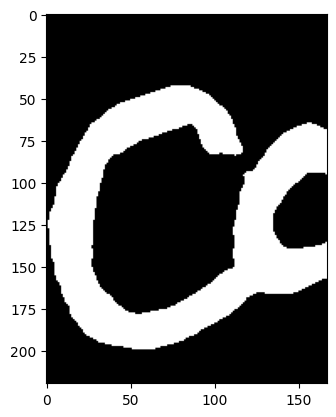

In [ ]:
a = []
b = []
img = largest_image
print(img.shape)
height = img.shape[0]
width = img.shape[1]

# Cut the image in half
width_cutoff = width // 2
s1 = img[:, :width_cutoff]
s2 = img[:, width_cutoff:]
a.append(s1)
b.append(s2)


plt.imshow(s1, cmap='gray')
#plt.imshow(s2,  cmap='gray')

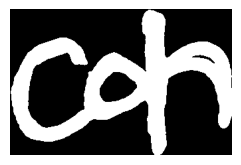

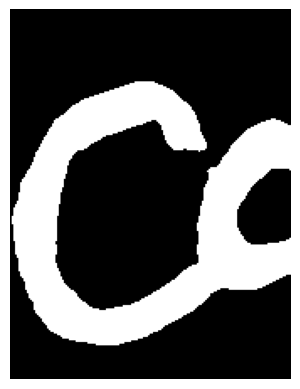

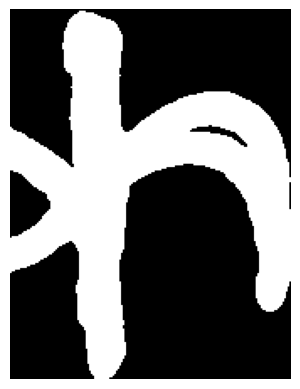

In [ ]:
'''
img = images_cropped_1[i]
img = img[0:0+height_2, num:num + num2 - num]
temp.append(img)
'''
#final  = xyz+temp2
charImgs = xyz+temp2 +a+b

  #print(charImgs)

figure = plt.figure(figsize=(20, 20))
for i in range(len(charImgs)):
  figure.add_subplot(6,6,i+1)
  plt.imshow(charImgs[i], cmap='gray')
  plt.axis('off')
  plt.savefig(f"{output}/lala15_{i}.png",bbox_inches='tight', pad_inches=0)
  plt.show()

#We do some processing on the characters that we acquired before to make sure
#they are ready to fill in the model for prediction.
processedCharImgs = []
for i in range(len(charImgs)):
  (tH, tW) = charImgs[i].shape
  #print(tH,tW)
  #plt.imshow(charImgs[i])
  charImgs[i] = charImgs[i].astype("uint8") * 255.0
  #print(tH)
  #print(tW)
  if tW > tH:
    charImgs[i] = imutils.resize(charImgs[i], width=32)
  elif tH > tW:
    charImgs[i] = imutils.resize(charImgs[i], height=32)

  (tH, tW) = charImgs[i].shape
  dX = int(max(0, 32-tW) / 2.0)
  dY = int(max(0, 32-tH) / 2.0)

  paddedImg = cv2.copyMakeBorder(charImgs[i], top=dY, bottom=dY, left=dX, right=dX, borderType=cv2.BORDER_CONSTANT, value=(0, 0, 0))
  paddedImg = cv2.resize(paddedImg, (32, 32))

  paddedImg = paddedImg.astype("uint8") * 255.0
  paddedImg = np.expand_dims(paddedImg, axis=-1)


  processedCharImgs.append(paddedImg)
#paddedImgs contains the images that will be sent to the model for prediction


In [ ]:
'''
from PIL import Image
import os

# Define the folder path containing the images
folder_path = '/content/drive/My Drive/Colab Notebooks/segment'

# Ensure the folder path exists
if not os.path.exists(folder_path):
    print(f"The folder '{folder_path}' does not exist.")
    exit()

# Get a list of all files in the folder
file_list = os.listdir(folder_path)

# Filter for image files (you can customize this based on your image file extensions)
image_extensions = ['.jpg', '.jpeg', '.png', '.gif', '.bmp']
image_files = [file for file in file_list if any(file.lower().endswith(ext) for ext in image_extensions)]

# Initialize variables to calculate the total dimensions and count of images
total_width = 0
total_height = 0
image_count = 0

# Loop through the image files to calculate total dimensions
for image_file in image_files:
    image_path = os.path.join(folder_path, image_file)

    # Open the image using Pillow
    with Image.open(image_path) as img:
        width, height = img.size
        total_width += width
        total_height += height
        image_count += 1

# Calculate the average dimensions
average_width = total_width / image_count
average_height = total_height / image_count

print(f"Average Dimensions: {average_width}x{average_height}")

# Display images with dimensions greater than the average
for image_file in image_files:
    image_path = os.path.join(folder_path, image_file)

    with Image.open(image_path) as img:
        width, height = img.size
        #if width > average_width or height > average_height:
        if width > average_width and height > average_height:
            img.show()
            print(f"Image: {image_file}, Dimensions: {width}x{height}")
'''

'\nfrom PIL import Image\nimport os\n\n# Define the folder path containing the images\nfolder_path = \'/content/drive/My Drive/Colab Notebooks/segment\'\n\n# Ensure the folder path exists\nif not os.path.exists(folder_path):\n    print(f"The folder \'{folder_path}\' does not exist.")\n    exit()\n\n# Get a list of all files in the folder\nfile_list = os.listdir(folder_path)\n\n# Filter for image files (you can customize this based on your image file extensions)\nimage_extensions = [\'.jpg\', \'.jpeg\', \'.png\', \'.gif\', \'.bmp\']\nimage_files = [file for file in file_list if any(file.lower().endswith(ext) for ext in image_extensions)]\n\n# Initialize variables to calculate the total dimensions and count of images\ntotal_width = 0\ntotal_height = 0\nimage_count = 0\n\n# Loop through the image files to calculate total dimensions\nfor image_file in image_files:\n    image_path = os.path.join(folder_path, image_file)\n\n    # Open the image using Pillow\n    with Image.open(image_path) a